In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
from time import sleep

In [2]:
import brian2 as b2
import pickle

In [3]:
import pandas as pd

In [4]:
from utilities import get_matrix_from_file, plot_weights

Using TensorFlow backend.


In [5]:
with open('highintensity/output/saved.pickle', 'rb') as f:
    saveobj = pickle.load(f)

Need efficient code using saveobj to do the following:

* check input spike train by visualising spikes for a few examples and comparing to label
* visualise spikes in processing layer excitory and inhibitory neurons
* plot distributions of spiking rates in processing layer excitory neurons
* identify assignments between processing layer excitory neurons and labels
* get prediction (and 'strength' = spike rate) for each example
* examine and plot weights

In [6]:
saveobj

{'rate_monitors': {'Ae': {'rate': array([0., 0., 0., ..., 0., 0., 0.]) * hertz,
   't': array([0.0000000e+00, 5.0000000e-04, 1.0000000e-03, ..., 4.9999985e+03,
          4.9999990e+03, 4.9999995e+03]) * second,
   'N': array(10000000, dtype=int32)},
  'Ai': {'rate': array([0., 0., 0., ..., 0., 0., 0.]) * hertz,
   't': array([0.0000000e+00, 5.0000000e-04, 1.0000000e-03, ..., 4.9999985e+03,
          4.9999990e+03, 4.9999995e+03]) * second,
   'N': array(10000000, dtype=int32)},
  'Xe': {'rate': array([10.20408163, 10.20408163, 12.75510204, ...,  0.        ,
           0.        ,  0.        ]) * hertz,
   't': array([0.0000000e+00, 5.0000000e-04, 1.0000000e-03, ..., 4.9999985e+03,
          4.9999990e+03, 4.9999995e+03]) * second,
   'N': array(10000000, dtype=int32)}},
 'spike_monitors': {'Ae': {'t': array([5.0000000e-02, 5.0000000e-02, 5.0000000e-02, ..., 4.9998375e+03,
          4.9998375e+03, 4.9998375e+03]) * second,
   'i': array([  0,  17,  32, ...,  85, 326, 327], dtype=int32),

In [8]:
# convert time to integers in units of 0.1 ms
spikes = {}
for p in saveobj['spike_monitors']: 
    spikes[p] = pd.DataFrame({'t': (saveobj['spike_monitors'][p]['t'] / (0.1*b2.ms)).astype(np.int),
                           'i'.format(p): saveobj['spike_monitors'][p]['i']})

# bins of 0.5s, i.e. one example
n_e = 400
imgsize = 28
total_example_time = saveobj['total_example_time']
for p in spikes:
    spikes[p]['tbin'] = (spikes[p]['t'] * 0.1*b2.ms / total_example_time).astype(np.int)
    if 'X' in p:
        spikes[p]['x'] = spikes[p]['i'] % imgsize
        spikes[p]['y'] = spikes[p]['i'] // imgsize

spikecounts = {p: spikes[p].groupby(['tbin', 'i'])['t'].count().rename('count') for p in spikes}

In [78]:
from matplotlib import animation, rc
from IPython.display import Image
rc('animation', html='html5')

def spike_animation(example_number=None,
                    gif_filename='spikes_example',
                    max_counts=50):
    if example_number is None:
        example_number = np.random.choice(spikes['Xe']['tbin'])
    spikes_ex = {p: spikes[p].set_index('tbin').loc[example_number] for p in spikes}
    dtexbin = 5 * b2.ms
    for p in spikes:
        spikes_ex[p]['texbin'] = ((spikes_ex[p]['t'] - spikes_ex[p]['t'].min()) / 50).astype(np.int)
    counts_ex = spikes_ex['Xe'].groupby(['texbin', 'x', 'y'])['t'].count().reset_index(level=['x', 'y'])

    tott = total_example_time / dtexbin
    times = np.arange(tott)
    
    fig, (axX, axA) = plt.subplots(1, 2, figsize=(15, 5))
    img = axX.imshow(np.zeros((imgsize, imgsize)),
                     vmin=0, vmax=max_counts)
    dotsX, = axX.plot([], [], 'r.')
    title = axX.set_title('', loc='right')
    axX.axis('off')
    
    dotsAe, = axA.plot([], [], 'r.')
    dotsAi, = axA.plot([], [], 'bo', mfc='none')
    axA.set_xlim(-1, tott * dtexbin/b2.ms)
    axA.set_ylim(-1, n_e)
    axA.set_xlabel('$t$ (ms)')
    axA.set_ylabel('neuron index')
    lineA, = axA.plot([], [], 'k-')
    fig.set_tight_layout(True)
    
    def init():
        a = img.get_array()
        a[:] *= 0
        dotsX.set_data([], [])
        dotsAe.set_data([], [])
        dotsAi.set_data([], [])
        title.set_text('')
        return [title, dotsX, dotsAe, dotsAi, lineA, img]

    def animate(t):
        artists = [title, dotsX, dotsAe, dotsAi, lineA]
        ti = dtexbin/b2.ms * (t+1)
        title.set_text('{} ms'.format(ti))
        if t in counts_ex.index:
            artists.append(img)
            k = counts_ex.loc[t]
            a = img.get_array()
            a[k['y'], k['x']] += 1
            dotsX.set_data(k['x'], k['y'])
        else:
            dotsX.set_data([], [])

        lineA.set_data([ti, ti], [-1, n_e])

        Ai_spikes = spikes_ex['Ai'][spikes_ex['Ai']['texbin'] <= t]
        dotsAi.set_data(Ai_spikes['texbin'] * dtexbin/b2.ms, Ai_spikes['i'])
        Ae_spikes = spikes_ex['Ae'][spikes_ex['Ae']['texbin'] <= t]
        dotsAe.set_data(Ae_spikes['texbin'] * dtexbin/b2.ms, Ae_spikes['i'])
        return artists

    duration = 10000  # ms
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=times, interval=duration/len(times),
                                   repeat=False, blit=True)
    plt.close()
    if gif_filename is not None:
        anim.save('{}.gif'.format(gif_filename), writer='imagemagick', fps=1000*len(times)/duration)
    return anim

In [79]:
anim = spike_animation()

In [80]:
Image(url='spikes_example.gif')

In [81]:
def plot_spike_distribution(counts):
    counts_mean = counts.groupby('i').mean()
    counts_std = counts.groupby('i').std()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.hist(counts_mean)
    ax1.set_xlabel('spikes per example');
    ax2.errorbar(counts_mean.index, counts_mean, counts_std, marker='', linestyle='none')
    ax2.set_xlabel('neuron index')
    ax2.set_ylabel('spikes per example');

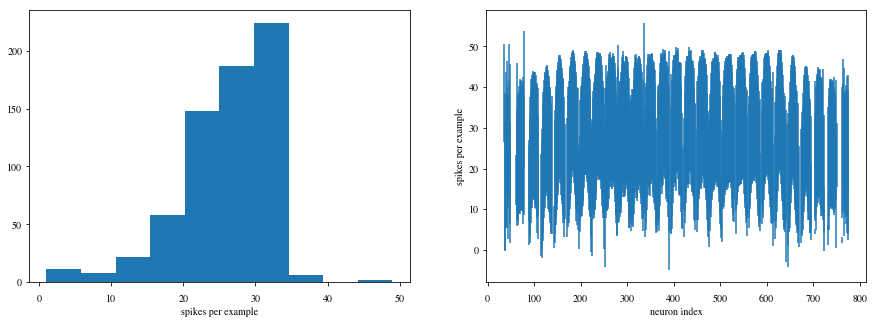

In [82]:
plot_spike_distribution(spikecounts['Xe'])

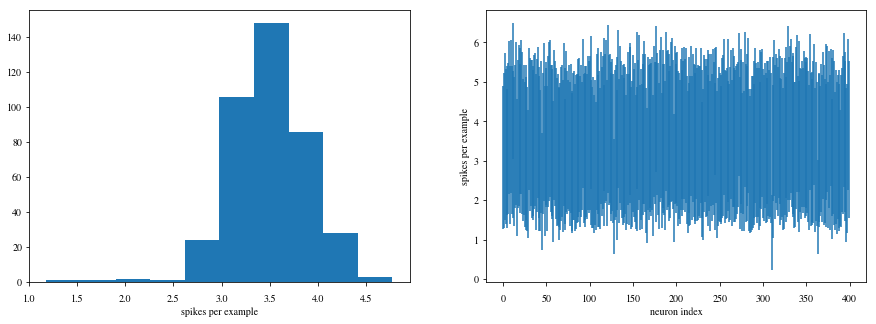

In [83]:
plot_spike_distribution(spikecounts['Ae'])

In [84]:
labels = pd.DataFrame({'label': saveobj['labels']}).rename_axis('tbin')

In [85]:
def get_assignments(counts, labels):
    counts = labels.join(counts)
    counts = counts.reset_index('tbin', drop=True)
    counts = counts.groupby(['i', 'label']).sum().reset_index('label')
    counts = counts.sort_values(['i', 'count'], ascending=[True, False])
    assignments = counts.groupby('i').head(1).drop(columns='count')
    return assignments

In [86]:
assignments = get_assignments(spikecounts['Ae'], labels)

In [87]:
len(labels), len(assignments)

(10000, 400)

In [88]:
def plot_assignment_distribution(assignments, labels):
    fig, ax = plt.subplots()
    n, b, p = ax.hist(labels['label'], density=True, bins=10, range=[-0.5, 9.5])
    ax.hist(assignments['label'], density=True, bins=b, histtype='step', lw=2)
    ax.set_xlabel('label')
    ax.xaxis.set_ticks(np.unique(labels))

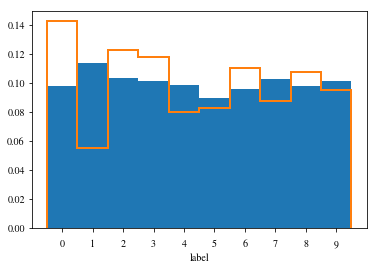

In [89]:
plot_assignment_distribution(assignments, labels)

In [90]:
def get_predictions(counts, assignments, labels=None):
    counts = pd.DataFrame(assignments).join(counts)
    counts = counts.rename(columns={'label': 'assignment'})
    counts = counts.groupby(['tbin', 'assignment']).mean()
    counts = counts.sort_values(['tbin', 'count'], ascending=[True, False])
    predictions = counts.groupby(['tbin']).head(1)
    predictions = predictions.reset_index('assignment')
    if labels is not None:
        predictions = predictions.join(labels)
    return predictions

In [91]:
predictions = get_predictions(spikecounts['Ae'], assignments, labels)

In [92]:
accuracy = (predictions['assignment'] == predictions['label']).sum() / len(predictions)

In [93]:
accuracy

0.8245

In [94]:
weights = get_matrix_from_file('norm/weights/XeAe.npy')

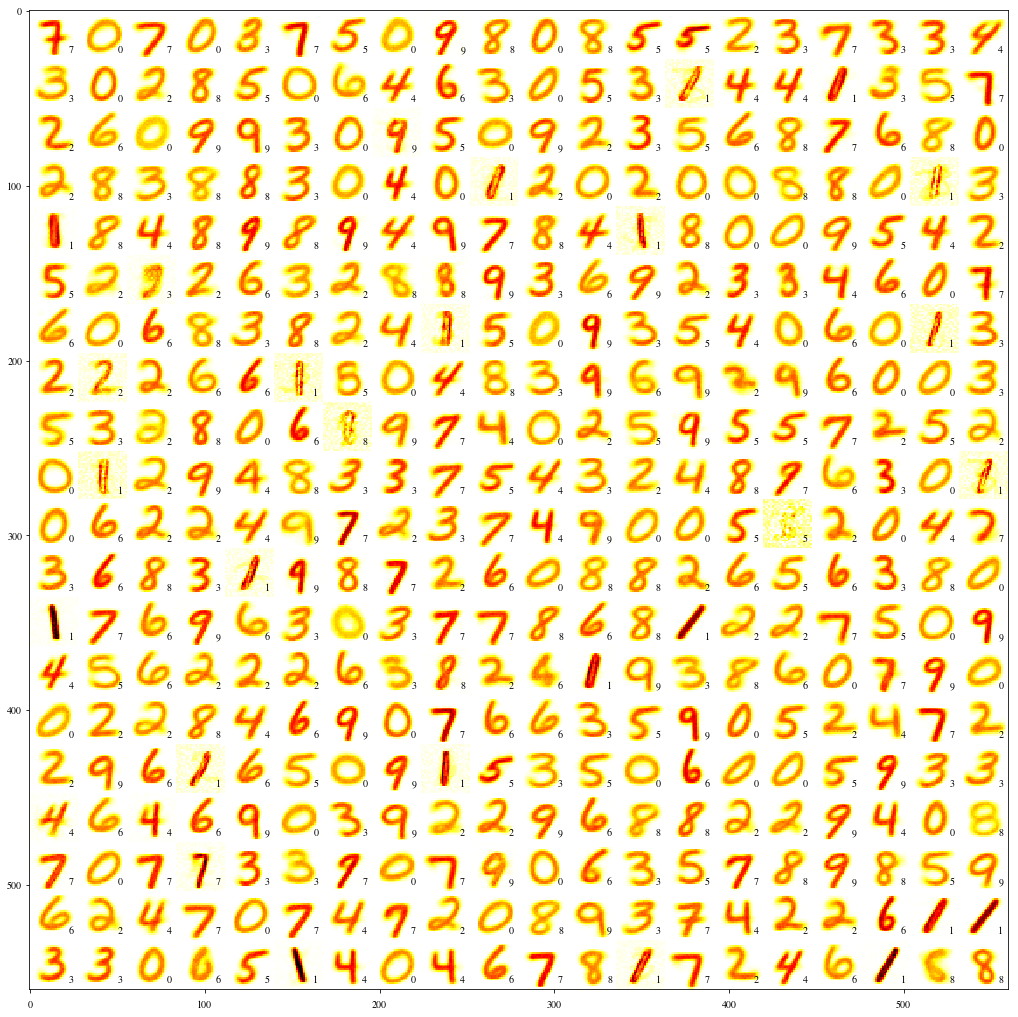

In [95]:
plot_weights(weights, assignments)

In [63]:
theta = np.load('norm/weights/theta_A.npy')

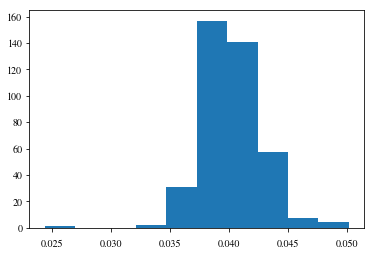

In [61]:
plt.hist(theta);

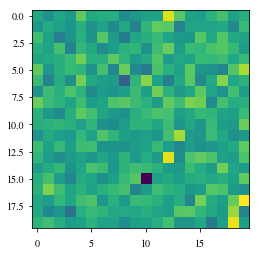

In [74]:
plt.imshow(theta.reshape((int(sqrt(len(theta))), -1)));

## Compare with results from original Brian1 code

In [34]:
inputLabels = np.load('../stdp-mnist/activity/inputNumbers10000.npy')

In [35]:
resultPopVecs = np.load('../stdp-mnist/activity/resultPopVecs10000.npy').astype(np.int)

In [36]:
(inputLabels == labels['label']).all()

True

In [37]:
x = pd.DataFrame(columns=['tbin', 'i', 'count'], dtype='int')

for i in np.arange(10000):
    df = pd.DataFrame({'tbin': i, 'i': np.arange(400), 'count': resultPopVecs[i]})
    df = df[df['count'] > 0]
    x = x.append(df)
    x = x.reset_index(drop=True)

In [38]:
spikecounts_Ae_brian1 = x.set_index(['tbin', 'i'])['count']

In [39]:
df = labels.join(spikecounts_Ae_brian1).reset_index(1)

In [40]:
assignments_brian1 = get_assignments(spikecounts_Ae_brian1, labels)

In [53]:
(assignments_brian1 == assignments).values.all()

True

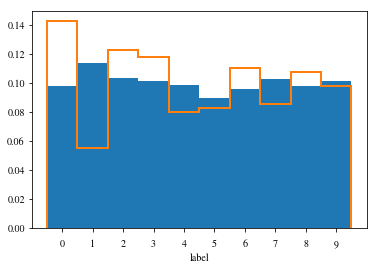

In [41]:
plot_assignment_distribution(assignments_brian1, labels)

In [42]:
predictions_brian1 = get_predictions(spikecounts_Ae_brian1, assignments_brian1, labels)

In [43]:
accuracy_brian1 = (predictions_brian1['assignment'] == predictions_brian1['label']).sum() / len(predictions_brian1)

In [44]:
accuracy_brian1

0.8721

In [47]:
weights_brian1 = get_matrix_from_file('weights/XeAe.npy')

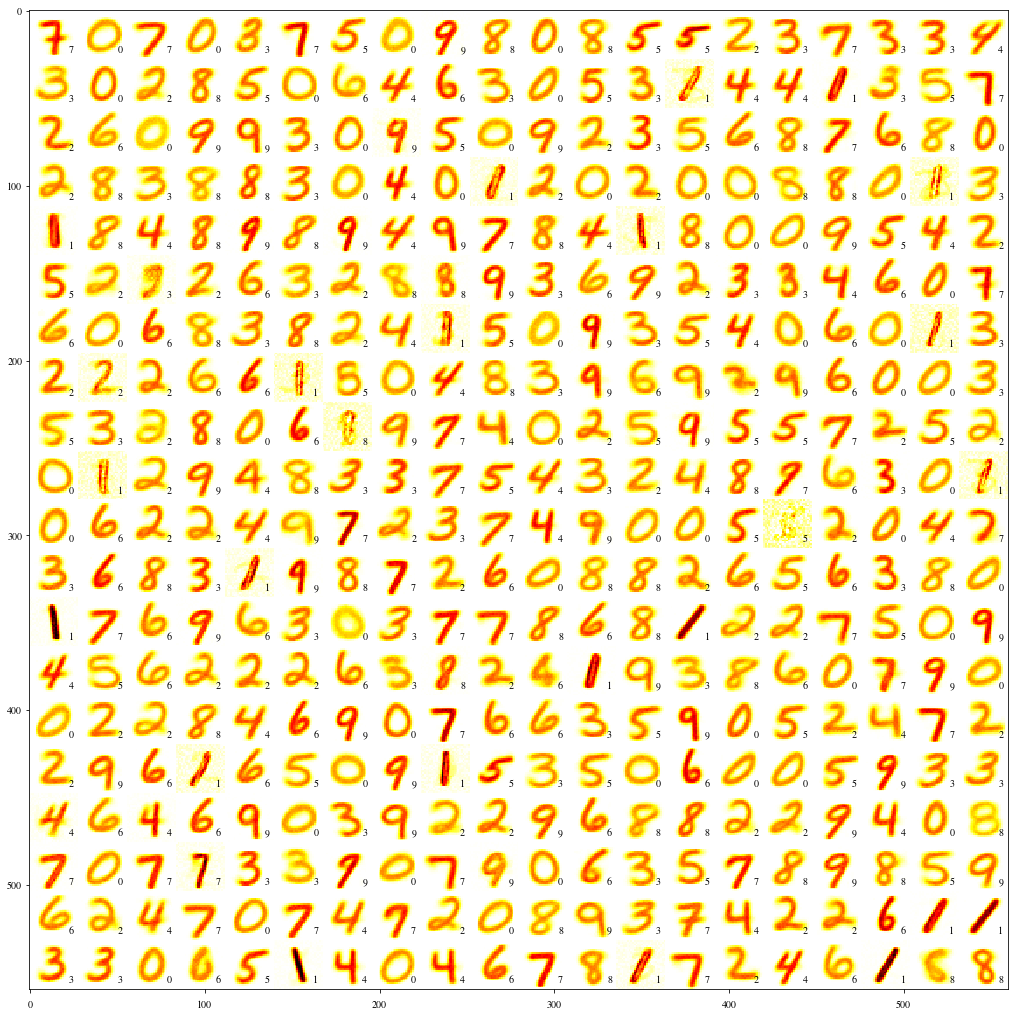

In [48]:
plot_weights(weights_brian1, assignments_brian1)